# Modeling

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display, Image
import re
import pydotplus

In [19]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [20]:
# Load the dataset
file_path = 'data/processed/uhi.csv'
uhi_data = pd.read_csv(file_path)

In [21]:
# Convert the 'date' column to datetime format
uhi_data['date'] = pd.to_datetime(uhi_data['date'])

# Replace inf values with NaN
uhi_data = uhi_data.replace([np.inf, -np.inf], np.nan)

In [22]:
# Encode categorical variables
label_encoder = LabelEncoder()
uhi_data['city'] = label_encoder.fit_transform(uhi_data['city'])
uhi_data['uhi_observed'] = label_encoder.fit_transform(uhi_data['uhi_observed'])

In [23]:
# Select features and target
X = uhi_data.drop(columns=['uhi_observed', 'date', 'zipcode'])
y = uhi_data['uhi_observed']

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id="models--and--hyperparameters"></a>
## Models and Hyperparameters

In [26]:
# Define models and hyperparameters for GridSearchCV
models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier()
}

In [27]:
param_grid = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
        'class_weight': [None, 'balanced']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

In [28]:
# Perform GridSearchCV for each model
best_estimators = {}
for model_name in models:
    print(f"\nPerforming GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")


Performing GridSearchCV for RandomForest...
Best Parameters for RandomForest: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Performing GridSearchCV for SVC...
Best Parameters for SVC: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}

Performing GridSearchCV for KNeighbors...
Best Parameters for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


<a id="evaluation"></a>
## Evaluation

In [29]:
# Cross-validation and evaluation
for model_name, model in best_estimators.items():
    print(f"\nCross-validation results for {model_name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Mean CV Accuracy for {model_name}: {scores.mean():.2f}")

    # Fit the model on training data and evaluate on test data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Final Evaluation Step
    print(f"\nFinal Evaluation for {model_name} on Test Data:")
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)


Cross-validation results for RandomForest...
Mean CV Accuracy for RandomForest: 0.89

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      5812
           1       0.89      0.87      0.88      4271

    accuracy                           0.90     10083
   macro avg       0.90      0.90      0.90     10083
weighted avg       0.90      0.90      0.90     10083


Final Evaluation for RandomForest on Test Data:
Accuracy: 0.90
Confusion Matrix:
[[5333  479]
 [ 541 3730]]

Cross-validation results for SVC...
Mean CV Accuracy for SVC: 0.84

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5812
           1       0.83      0.81      0.82      4271

    accuracy                           0.85     10083
   macro avg       0.85      0.84      0.84     10083
weighted avg       0.85      0.85      0.85     10083


Final Eva

RandomForest is the best-performing model with the highest accuracy (0.90) and balanced precision and recall across both classes. The model benefits from its ability to handle a variety of features and manage the complexity of the dataset. SVC and KNeighbors are slightly less accurate, with accuracies of 0.85 and 0.82 respectively.

Before continuing with RandomForest reesults analysis I'd like to reverse the scaling applied by StandardScaler and retrain the RandomForest on the original data. This will help with interpretability since all features will have their original scales.

In [32]:
# To reverse the scaling
X_train_original = scaler.inverse_transform(X_train)
X_test_original = scaler.inverse_transform(X_test)

In [33]:
# Retrain RandomForest on original features for interpretability
rf_best_model = RandomForestClassifier(**best_estimators['RandomForest'].get_params())
rf_best_model.fit(X_train_original, y_train)

RandomForestClassifier(max_depth=20, max_features=None, n_estimators=300)

<a id="analyzing--results"></a>
## Analyzing Results

### Feature Importances


Feature Importances for RandomForest:
avg_ndvi                            0.250651
avg_lst_c                           0.138930
day_length_sec                      0.077692
max_air_temp_c                      0.072115
wind_speed_kmh                      0.062273
wind_dir_degrees                    0.054678
atm_pressure_hpa                    0.051681
min_air_temp_c                      0.050458
water_vapor_pressure_pa             0.046259
developed_high_intensity_pct        0.046254
city                                0.034011
deciduous_forest_pct                0.013817
precipitation_mm                    0.012081
evergreen_forest_pct                0.011441
developed_low_intensity_pct         0.010680
developed_medium_intensity_pct      0.010397
shrub_scrub_pct                     0.009460
developed_open_space_pct            0.008778
population_density                  0.008654
barren_land_pct                     0.006167
percent_impervious                  0.005744
emergent_herbace

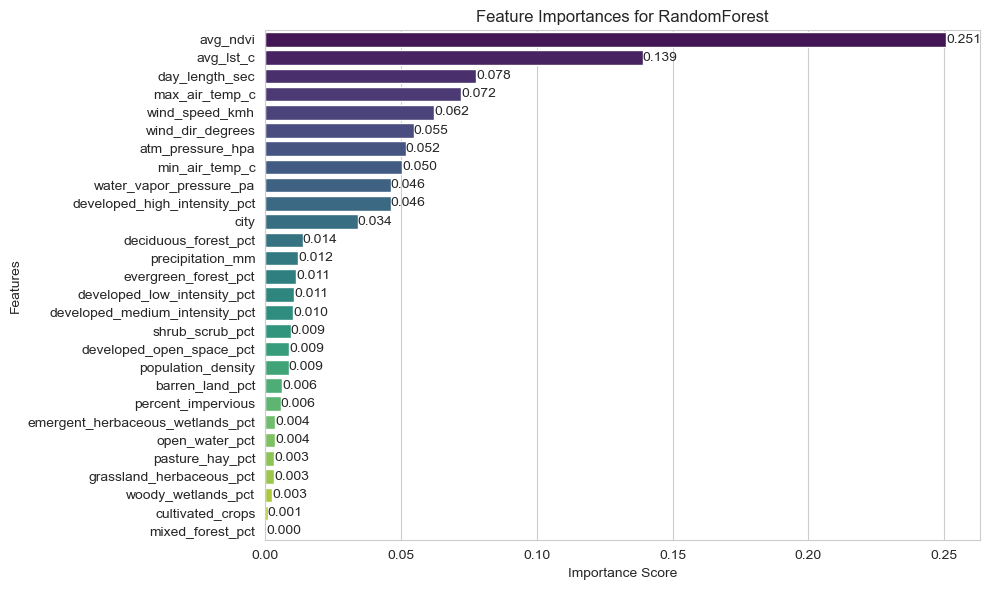

In [36]:
importances = rf_best_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print and plot feature importance
print("\nFeature Importances for RandomForest:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
for index, value in enumerate(feature_importances.values):
    plt.text(value, index, f'{value:.3f}', va='center')
plt.title('Feature Importances for RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Feature Importance Interpretation

The chart shows that avg_ndvi (vegetation index) and avg_lst_c (land surface temperature) are the most important factors for predicting Urban Heat Island (UHI) effects, highlighting the cooling impact of vegetation and the role of surface heating. Day length, max air temperature, wind speed, and high-intensity developed areas also contribute significantly. Less impactful features include forest types, precipitation, and crop areas.

### Decision Tree

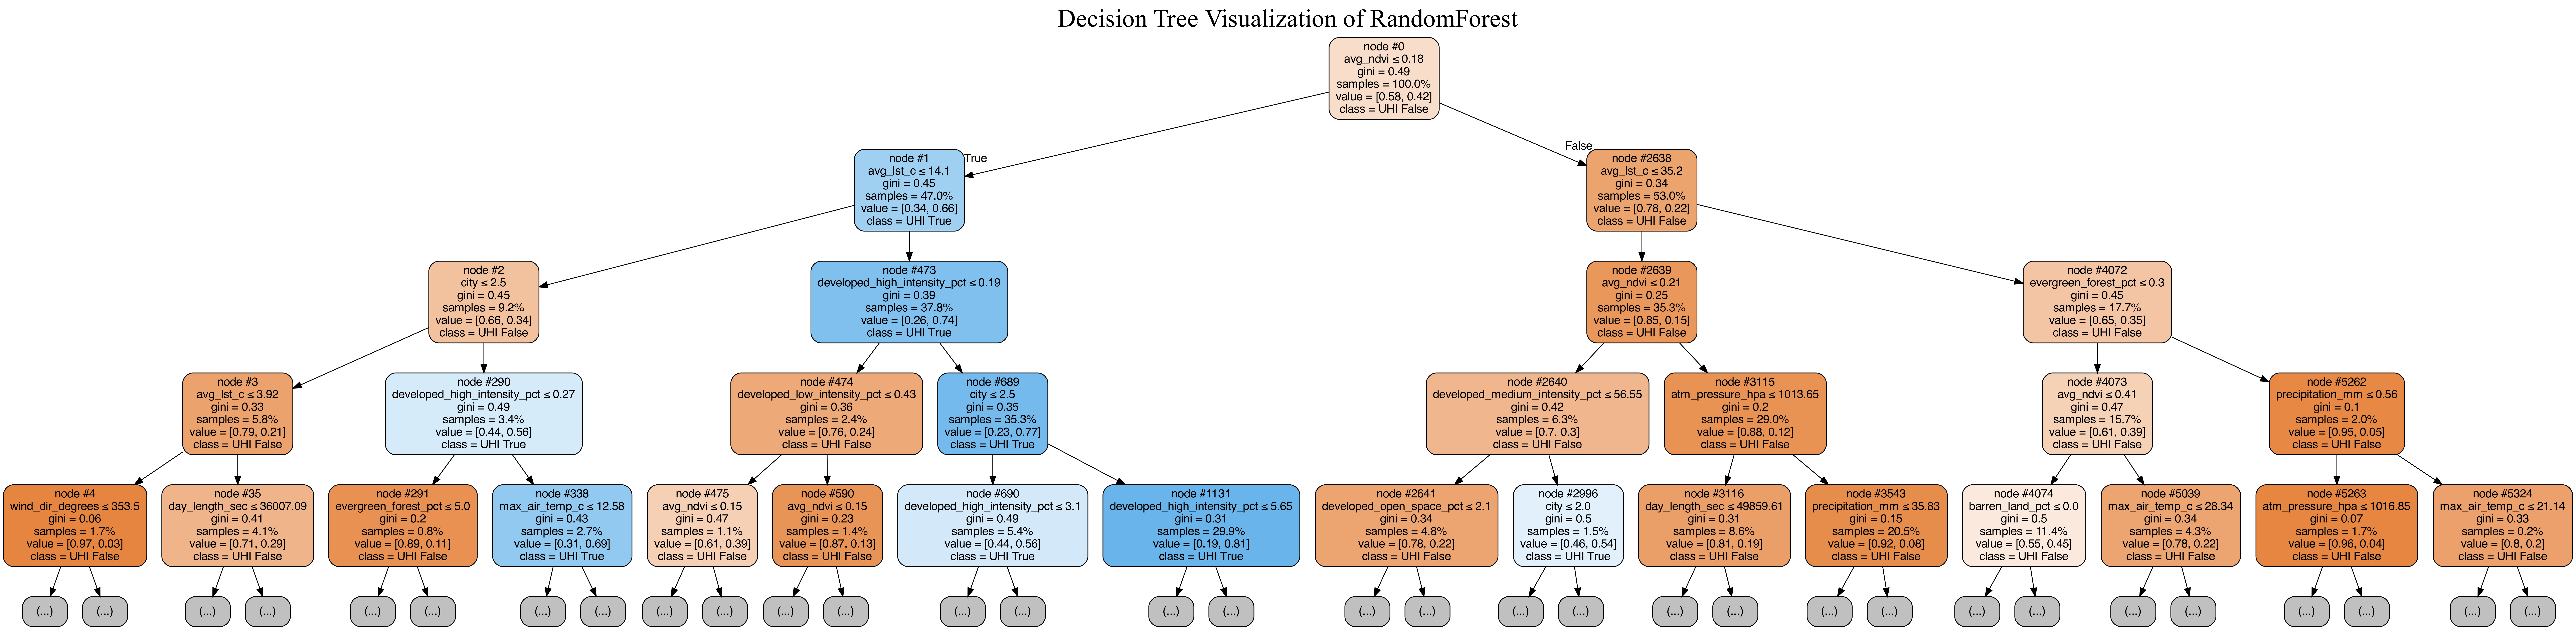

In [37]:
# Visualize one of the decision trees in the RandomForest using Graphviz
class_names = ['UHI False', 'UHI True']

estimator = rf_best_model.estimators_[0]
dot_data = export_graphviz(
    estimator, 
    out_file=None, 
    feature_names=feature_names, 
    filled=True, 
    rounded=True, 
    special_characters=True, 
    max_depth=4, 
    node_ids=True, 
    proportion=True, 
    precision=2, 
    label='all', 
    class_names=class_names)

title = 'Decision Tree Visualization of RandomForest'
lines = dot_data.splitlines()
lines.insert(1, f'graph [label="{title}", labelloc="t", fontsize=30, dpi=300];')

dot_data_with_title = "\n".join(lines)
graph = graphviz.Source(dot_data_with_title)
graph.format = 'png'
graph.render(filename='images/tree_visualization', format='png', cleanup=False)
display(Image(filename='images/tree_visualization.png'))

Decision Tree Interpretation

- The tree starts by splitting on avg_ndvi (vegetation index) at a threshold of 0.218. NDVI is a critical measure of vegetation density and health. A value below 0.218 suggests low vegetation coverage, which often corresponds to urbanized areas with higher susceptibility to UHI. A value above 0.218 indicates healthier vegetation, typically reducing the likelihood of UHI.
- Certain cities may have distinct land use or vegetation patterns that make UHI more likely.
- If high-intensity development (developed_high_intensity_pct) exceeds this threshold, the model strongly predicts True (UHI observed), showing the direct role of impervious surfaces in driving UHI.
- Wind direction (wind_dir_degrees) suggests wind movement may influence heat dispersion.
- Day length (day_length_sec) shows that shorter days may have less solar heating, reducing UHI intensity.
- High evergreen forest cover (evergreen_forest_pct) reduces UHI likelihood, emphasizing the cooling effects of forested areas.
- Higher precipitation (precipitation_mm) and lower barren land (barren_land_pct) typically lead to a False prediction for UHI, indicating that moisture and vegetation mitigate heat retention.

<a id="conclusions"></a>
## Conclusions
Urbanization characteristics and specific local climate factors contribute significantly to the Urban Heat Island (UHI) effect in different cities:.

- Vegetation matters most. Areas with low greenery, measured by avg_ndvi, are much more likely to experience UHI. Trees and plants play a huge role in cooling urban areas.
- Urban development. High-density development (like big buildings and paved areas) is strongly linked to UHI. Open spaces with more grass and vegetation help reduce these effects.
- Hot surfaces. Land surface temperature (avg_lst_c) is a key indicator of how hot an area gets, especially in urban zones.
- Day length and weather. Longer days and calm weather (low wind speeds) can make UHI worse since there’s less opportunity for heat to dissipate.
- Forest cover. Forested areas, especially evergreen trees, are very effective at keeping temperatures lower.
- Features like rainfall, population density, and certain types of land cover (like farmland) don’t play as big of a role but still provide some context.

The findings emphasize the interplay of vegetation, urbanization, and climate in driving UHI effects. Urban planners and policymakers should focus on increasing vegetation, reducing impervious surfaces, and adopting sustainable designs to mitigate UHI, improving urban resilience to climate change.